# 기본 함수 및 라이브러리 로드

In [1]:
# 경고 제어
import warnings
warnings.filterwarnings('ignore')

# 기본 전처리
import numpy as np
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.4f}'.format

# 시각화
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (12, 9)
from scipy.stats import norm

from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## 필요 함수 로드

In [2]:
def get_object_type(df):
    """ 
    상권코드의 type을 str로 바꿈
    상권_이름을 삭제
    """
    
    df['상권_코드'] = df['상권_코드'].apply(lambda x: str(x))
    try:
        df.drop('상권_이름', inplace=True, axis=1)
    except:
        pass
    return df

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
### Scaler들의 함수를 정의함 ###
def get_Standard(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_MinMaxScaler(df_x):
    m_scaler = MinMaxScaler()
    return m_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_Stan_log1p(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x.agg(np.log1p)).reshape(-1, 1))

def get_log1p(df_x):
    return df_x.agg(np.log1p)

## 검정 함수
### vif 관련 함수

##### AIC 시각화

In [4]:
def vis_AIC_step(result):
    fig = plt.figure(figsize=(10, 10))
    fig.set_facecolor('white')
    
    font_size = 15
    steps = range(1, result.shape[0]+1)
    AIC = result['AIC'].to_list()
    features = [f'step {i+1}\n' + '\n'.join(s) for i, s in enumerate(result['Features'])]
    
    plt.xticks(steps, features, fontsize=12)
    plt.plot(steps, AIC, marker='o')
    
    plt.ylabel('AIC', fontsize=font_size)
    plt.grid(True)
    plt.show()

### 최적화 함수

In [5]:
def get_best_summary_by_A(model):
    return model.sort_values('AIC').head(1)['SUMMARY'].iloc[0]

def get_best_feature_by_A(model):
    return model.sort_values('AIC').head(1)['Features'].iloc[0]

def get_adj_r_squared_by_A_model(model):
    summary = get_best_summary_by_A(model)
    return float(str(summary).split('Adj. R-squared:')[1].split('Method')[0])

### PCA 함수

In [6]:
from sklearn.decomposition import PCA

def decompo_pca(df, col, new_col):
    
    pca = PCA(n_components=1)
    df[new_col] = pca.fit_transform(df[col])
    df.drop(col, axis=1, inplace=True)
    
    return df

# Data Load

In [7]:
df_i3= pd.read_csv('../data/indicator/preprocess_cul.csv')
df_i3 = df_i3.set_index('상권_코드')
df_i3.head(3)

,리뷰_수,평균_별점,사장님_댓글_비율,맛있다_비율,친절_비율,분위기_비율,싸다_비율,비싸다_비율,F_유저_언급량,F_버즈_언급량,F_관람환경_매력도,F_먹거리_매력도,F_취향_매력도,F_맛_매력도,F_입소문_매력도,F_포토제닉_매력도,F_제품_단가,D_유저_언급량,D_버즈_언급량,D_관람환경_매력도,D_먹거리_매력도,D_취향_매력도,D_맛_매력도,D_입소문_매력도,D_포토제닉_매력도,D_제품_단가
상권_코드,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,1392.0000,4.4145,0.0812,0.9620,1.0037,1.3616,0.6327,1.0253,2.7458,3.2419,2.9265,2.9458,3.3263,-0.3154,-0.2962,0.0844,28156.3910,2.2927,3.3450,2.8440,2.7547,3.1277,-0.5010,-0.5903,-0.2173,9324.6218
1000002,424.0000,4.1981,0.0024,0.9209,0.8238,0.6050,0.3077,0.6556,2.7458,3.2419,2.9265,2.9458,3.3263,-0.3154,-0.2962,0.0844,28156.3910,2.2927,3.3450,2.8440,2.7547,3.1277,-0.5010,-0.5903,-0.2173,9324.6218
1000003,6280.0000,4.3665,0.0621,1.0208,1.1733,1.4607,0.8519,1.1738,2.7458,3.2419,2.9265,2.9458,3.3263,-0.3154,-0.2962,0.0844,28156.3910,2.2927,3.3450,2.8440,2.7547,3.1277,-0.5010,-0.5903,-0.2173,9324.6218


In [8]:
df_X = df_i3.copy()
df_y = pd.read_csv('../data/base_data/target.csv', index_col='상권_코드')

# 1차 분석

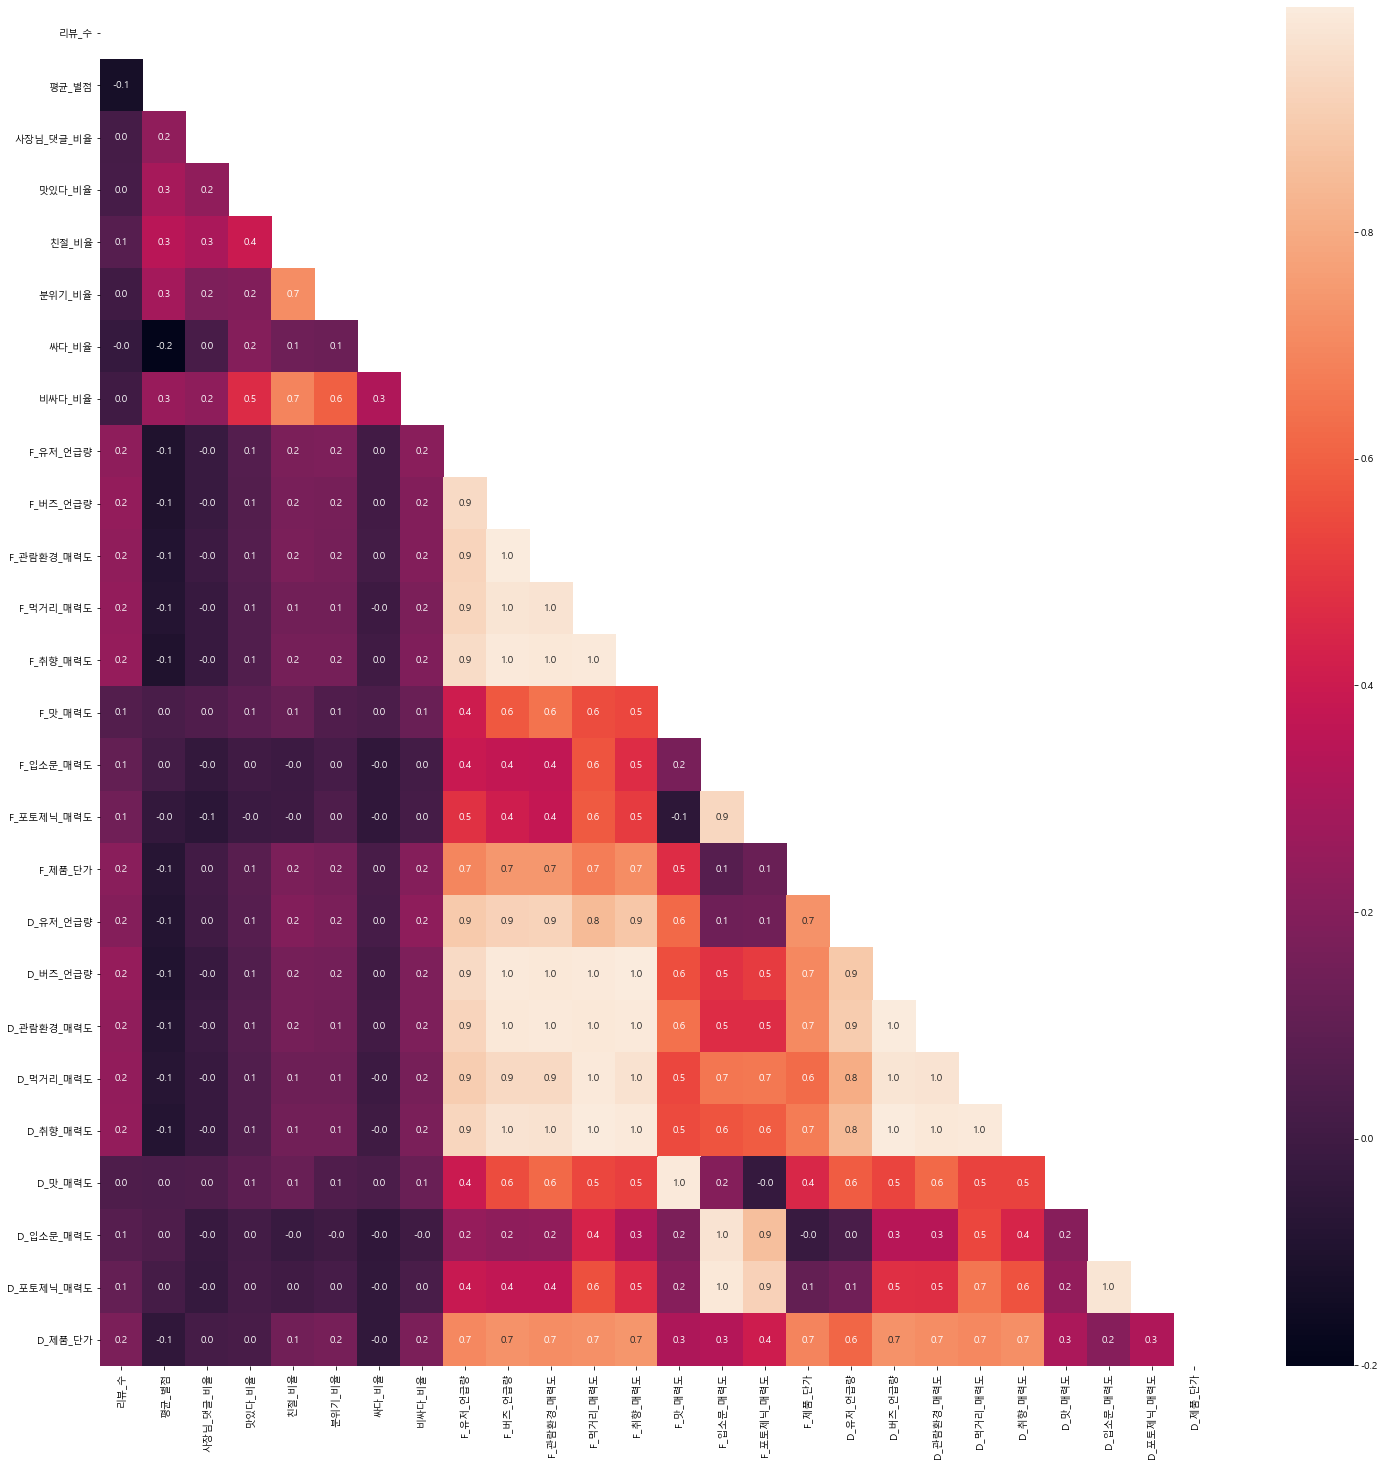

In [9]:
plt.figure(figsize=(25, 25))

mask = np.zeros_like(df_X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_X.corr(), mask=mask, fmt='.1f', annot=True);

In [10]:
model = sm.OLS(df_y, df_X)
regr = model.fit()
data = regr.summary()
data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 면적당_매출   R-squared (uncentered):                   0.611
Model:                            OLS   Adj. R-squared (uncentered):              0.603
Method:                 Least Squares   F-statistic:                              77.67
Date:                Sat, 25 Dec 2021   Prob (F-statistic):                   1.08e-186
Time:                        15:14:15   Log-Likelihood:                         -5619.2
No. Observations:                1009   AIC:                                  1.128e+04
Df Residuals:                     989   BIC:                                  1.138e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
리뷰_수           0.0071      0.001      5.253      0.000       0.004       0.010
평균_별점         27.9048     10.203      2.735      0.006       7.883      47.927
사장님_댓글_비율     13.1257     16.246      0.808      0.419     -18.755      45.006
맛있다_비율         8.2311     43.332      0.190      0.849     -76.801      93.264
친절_비율         -8.6913      8.164     -1.065      0.287     -24.711       7.329
분위기_비율        -8.7755      5.045     -1.739      0.082     -18.677       1.125
싸다_비율          5.1371      2.388      2.151      0.032       0.451       9.824
비싸다_비율         3.6627      8.389      0.437      0.662     -12.800      20.125
F_유저_언급량      -1.3453     15.622     -0.086      0.931     -32.001      29.311
F_버즈_언급량      46.9325     52.865      0.888      0.375     -56.808     150.673
F_관람환경_매력도    45.3160    119.056      0.381      0.704    -188.316     278.948
F_먹거리_매력도   -101.3990     73.820     -1.374      0.170    -246.261      43.463
F_취향_매력도     140.8389     73.380      1.919      0.055      -3.159     284.837
F_맛_매력도       -1.6165    164.362     -0.010      0.992    -324.155     320.922
F_입소문_매력도   -148.3315     57.419     -2.583      0.010    -261.008     -35.655
F_포토제닉_매력도    93.9063    104.422      0.899      0.369    -111.008     298.820
F_제품_단가       -0.0023      0.001     -1.650      0.099      -0.005       0.000
D_유저_언급량       3.4639     15.385      0.225      0.822     -26.728      33.655
D_버즈_언급량     -49.1709     32.242     -1.525      0.128    -112.442      14.101
D_관람환경_매력도   -38.1641     82.937     -0.460      0.646    -200.918     124.589
D_먹거리_매력도    123.4740     76.325      1.618      0.106     -26.303     273.251
D_취향_매력도    -145.4534     85.250     -1.706      0.088    -312.745      21.838
D_맛_매력도       11.0068    101.633      0.108      0.914    -188.435     210.449
D_입소문_매력도    172.6449     72.314      2.387      0.017      30.739     314.550
D_포토제닉_매력도   -96.2826     98.101     -0.981      0.327    -288.792      96.226
D_제품_단가       -0.0028      0.004     -0.724      0.469      -0.010       0.005
==============================================================================
Omnibus:                      770.430   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21456.482
Skew:                           3.223   Prob(JB):                         0.00
Kurtosis:                      24.652   Cond. No.                     1.27e+16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenva

## PCA

In [11]:
cols = ['F_유저_언급량','F_버즈_언급량','F_관람환경_매력도','F_먹거리_매력도','F_취향_매력도']
df_X = decompo_pca(df_X, cols, 'food_SNS_언급량_pca')
df_X.head()

cols = [ 'F_입소문_매력도', 'F_포토제닉_매력도']
df_X = decompo_pca(df_X, cols, 'food_입소문_포토제닉_pca')
df_X.head()

cols = ['D_유저_언급량','D_버즈_언급량','D_관람환경_매력도','D_먹거리_매력도','D_취향_매력도']
df_X = decompo_pca(df_X, cols, 'dessert_SNS_언급량_pca')
df_X.head()

cols = ['D_입소문_매력도', 'D_포토제닉_매력도']
df_X = decompo_pca(df_X, cols, 'dessert_입소문_포토제닉_pca')
df_X.head()

,리뷰_수,평균_별점,사장님_댓글_비율,맛있다_비율,친절_비율,분위기_비율,싸다_비율,비싸다_비율,F_맛_매력도,F_제품_단가,D_맛_매력도,D_제품_단가,food_SNS_언급량_pca,food_입소문_포토제닉_pca,dessert_SNS_언급량_pca,dessert_입소문_포토제닉_pca
상권_코드,,,,,,,,,,,,,,,,
1000001,1392.0000,4.4145,0.0812,0.9620,1.0037,1.3616,0.6327,1.0253,-0.3154,28156.3910,-0.5010,9324.6218,4.4795,-0.2384,4.1395,-0.6383
1000002,424.0000,4.1981,0.0024,0.9209,0.8238,0.6050,0.3077,0.6556,-0.3154,28156.3910,-0.5010,9324.6218,4.4795,-0.2384,4.1395,-0.6383
1000003,6280.0000,4.3665,0.0621,1.0208,1.1733,1.4607,0.8519,1.1738,-0.3154,28156.3910,-0.5010,9324.6218,4.4795,-0.2384,4.1395,-0.6383
1000004,1951.0000,4.2373,0.0159,0.9766,0.6351,0.8400,0.8945,0.9288,-0.3154,28156.3910,-0.5010,9324.6218,4.4795,-0.2384,4.1395,-0.6383
1000005,5527.0000,4.4255,0.0655,1.0013,1.0292,1.4835,0.8823,1.0803,-0.3154,28156.3910,-0.5010,9324.6218,4.4795,-0.2384,4.1395,-0.6383


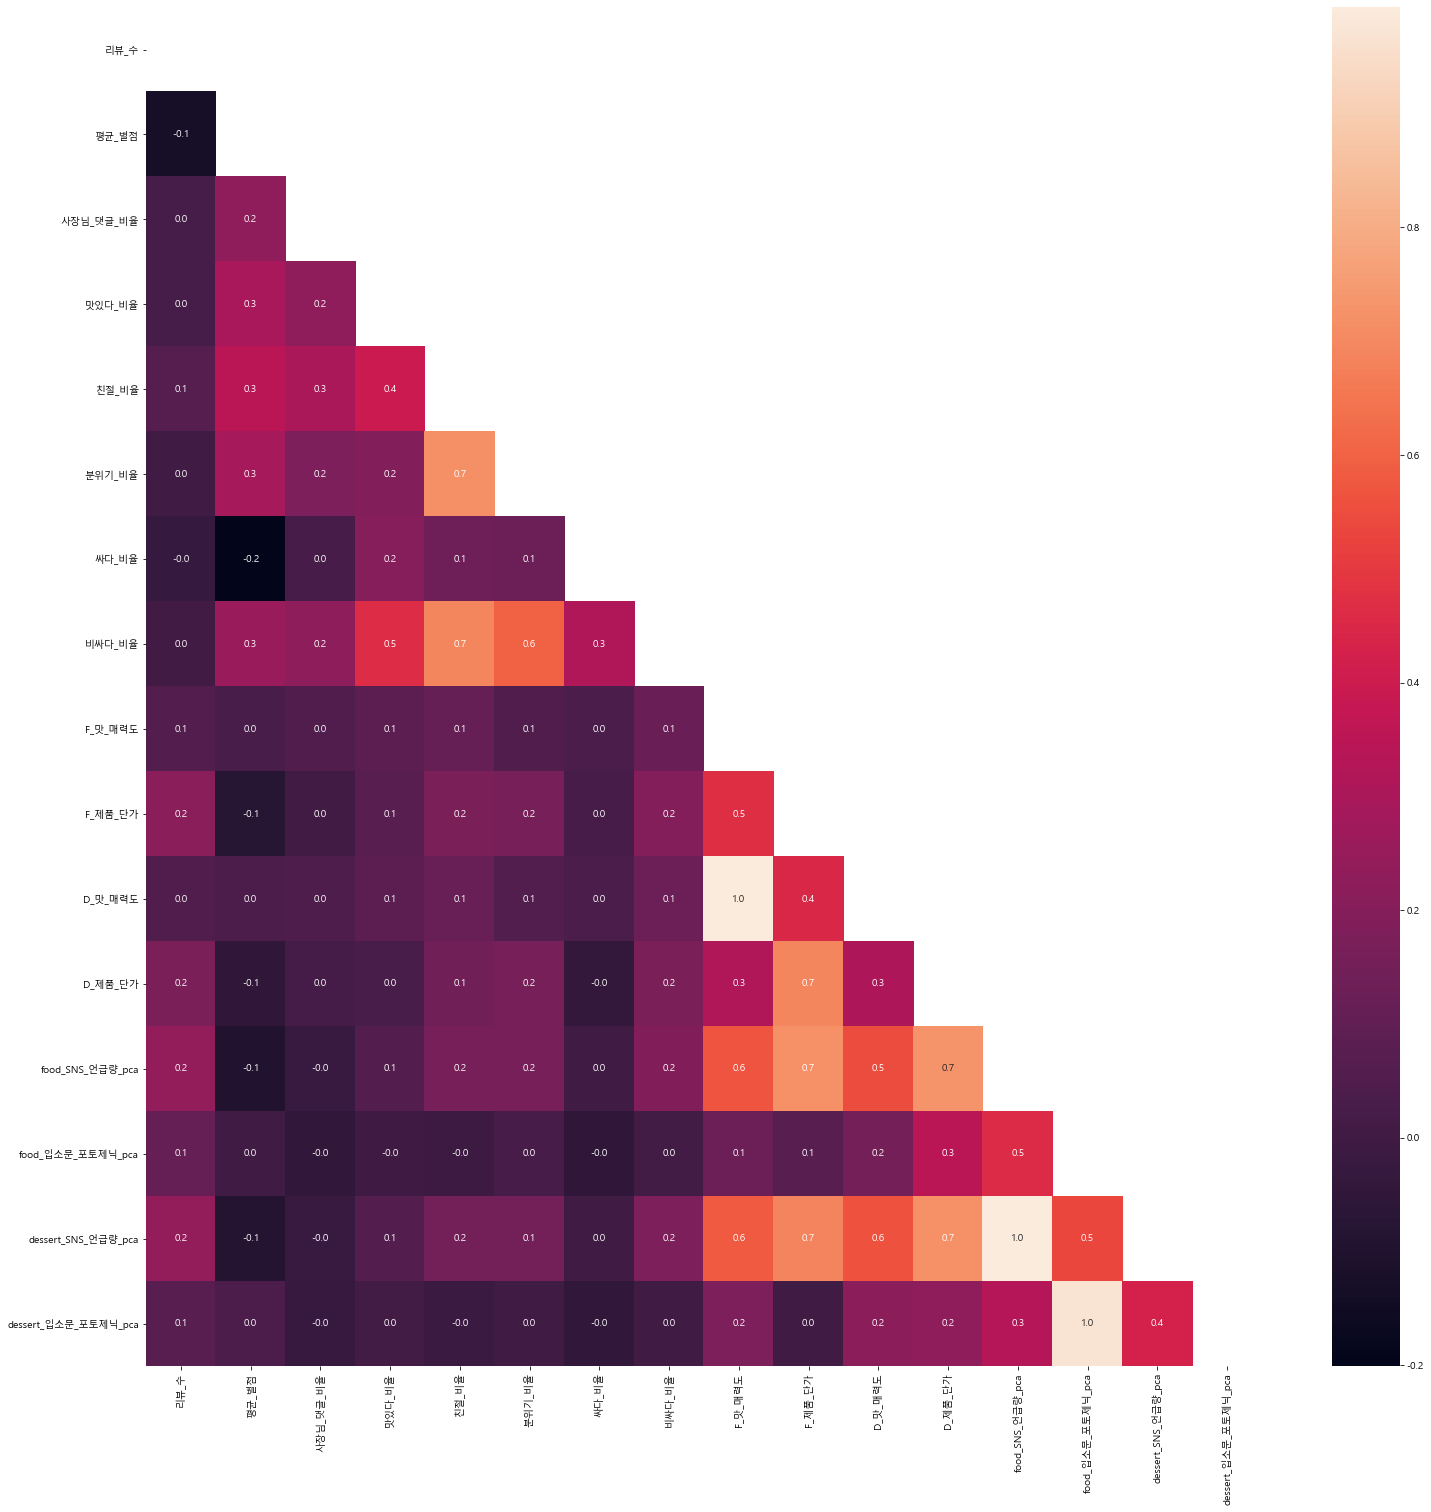

In [12]:
plt.figure(figsize=(25, 25))

mask = np.zeros_like(df_X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_X.corr(), mask=mask, fmt='.1f', annot=True);

In [13]:
model = sm.OLS(df_y, df_X)
regr = model.fit()
data = regr.summary()
data

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 면적당_매출   R-squared (uncentered):                   0.610
Model:                            OLS   Adj. R-squared (uncentered):              0.603
Method:                 Least Squares   F-statistic:                              96.88
Date:                Sat, 25 Dec 2021   Prob (F-statistic):                   8.15e-190
Time:                        15:14:17   Log-Likelihood:                         -5621.1
No. Observations:                1009   AIC:                                  1.127e+04
Df Residuals:                     993   BIC:                                  1.135e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
리뷰_수                     0.0071      0.001      5.294      0.000       0.004       0.010
평균_별점                   27.6817     10.150      2.727      0.007       7.763      47.600
사장님_댓글_비율               13.3664     16.162      0.827      0.408     -18.349      45.082
맛있다_비율                   4.8199     43.180      0.112      0.911     -79.914      89.554
친절_비율                   -9.1654      8.148     -1.125      0.261     -25.156       6.825
분위기_비율                  -8.6149      5.042     -1.709      0.088     -18.508       1.279
싸다_비율                    4.9582      2.386      2.078      0.038       0.276       9.641
비싸다_비율                   4.5597      8.343      0.547      0.585     -11.811      20.931
F_맛_매력도               -187.0109    163.583     -1.143      0.253    -508.019     133.997
F_제품_단가                 -0.0012      0.001     -1.022      0.307      -0.003       0.001
D_맛_매력도                105.7045    119.591      0.884      0.377    -128.975     340.384
D_제품_단가                 -0.0028      0.004     -0.742      0.458      -0.010       0.005
food_SNS_언급량_pca        11.8237     21.137      0.559      0.576     -29.655      53.302
food_입소문_포토제닉_pca     -117.7612     58.145     -2.025      0.043    -231.862      -3.660
dessert_SNS_언급량_pca     -4.1206     19.717     -0.209      0.835     -42.812      34.571
dessert_입소문_포토제닉_pca    98.3576     60.360      1.630      0.104     -20.090     216.806
==============================================================================
Omnibus:                      768.421   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21247.231
Skew:                           3.212   Prob(JB):                         0.00
Kurtosis:                      24.543   Cond. No.                     2.78e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
path = '../data/indicator/fs_cul.csv'
df_X.to_csv(path)
pd.read_csv(path).head()

,상권_코드,리뷰_수,평균_별점,사장님_댓글_비율,맛있다_비율,친절_비율,분위기_비율,싸다_비율,비싸다_비율,F_맛_매력도,F_제품_단가,D_맛_매력도,D_제품_단가,food_SNS_언급량_pca,food_입소문_포토제닉_pca,dessert_SNS_언급량_pca,dessert_입소문_포토제닉_pca
0,1000001,1392.0000,4.4145,0.0812,0.9620,1.0037,1.3616,0.6327,1.0253,-0.3154,28156.3910,-0.5010,9324.6218,4.4795,-0.2384,4.1395,-0.6383
1,1000002,424.0000,4.1981,0.0024,0.9209,0.8238,0.6050,0.3077,0.6556,-0.3154,28156.3910,-0.5010,9324.6218,4.4795,-0.2384,4.1395,-0.6383
2,1000003,6280.0000,4.3665,0.0621,1.0208,1.1733,1.4607,0.8519,1.1738,-0.3154,28156.3910,-0.5010,9324.6218,4.4795,-0.2384,4.1395,-0.6383
3,1000004,1951.0000,4.2373,0.0159,0.9766,0.6351,0.8400,0.8945,0.9288,-0.3154,28156.3910,-0.5010,9324.6218,4.4795,-0.2384,4.1395,-0.6383
4,1000005,5527.0000,4.4255,0.0655,1.0013,1.0292,1.4835,0.8823,1.0803,-0.3154,28156.3910,-0.5010,9324.6218,4.4795,-0.2384,4.1395,-0.6383


# 정규화

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols = df_X.columns
for col in cols:
    df_X[col] = scaler.fit_transform(np.array(df_X[col]).reshape(-1, 1))
    
df_X.describe()

,리뷰_수,평균_별점,사장님_댓글_비율,맛있다_비율,친절_비율,분위기_비율,싸다_비율,비싸다_비율,F_맛_매력도,F_제품_단가,D_맛_매력도,D_제품_단가,food_SNS_언급량_pca,food_입소문_포토제닉_pca,dessert_SNS_언급량_pca,dessert_입소문_포토제닉_pca
count,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000
mean,0.1001,0.7044,0.0803,0.6528,0.3204,0.2578,0.0637,0.2993,0.4158,0.4881,0.4654,0.5634,0.2246,0.2305,0.1940,0.3051
std,0.1347,0.1056,0.1340,0.1183,0.1411,0.1561,0.0582,0.1145,0.1741,0.2337,0.1646,0.2589,0.2980,0.2068,0.2718,0.1855
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0178,0.6493,0.0000,0.5921,0.2314,0.1567,0.0408,0.2269,0.3613,0.3021,0.4172,0.4356,0.0548,0.1565,0.0390,0.2511
50%,0.0517,0.7031,0.0312,0.6588,0.3025,0.2227,0.0578,0.2891,0.3815,0.4364,0.4373,0.5506,0.0813,0.1972,0.0695,0.2810
75%,0.1223,0.7600,0.0994,0.7257,0.3882,0.3217,0.0744,0.3522,0.4144,0.7092,0.4634,0.7620,0.2164,0.2255,0.1972,0.3013
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


# 점수 지수화

In [16]:
i3_df = pd.DataFrame(columns=['i3_ind1'], index=df_X.index)

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

lr = LinearRegression()
model = lr.fit(df_X, df_y)
coef = model.coef_.reshape(-1)

scaler = MinMaxScaler()
coef_df = np.array((df_X * coef).sum(axis=1))
i3_indi = scaler.fit_transform(coef_df.reshape(-1, 1))
i3_df['i3_ind1'] = i3_indi.reshape(-1)

i3_df.head()

,i3_ind1
상권_코드,
1000001,0.3319
1000002,0.2416
1000003,0.6084
1000004,0.3868
1000005,0.5869


# 최종 폴더 저장

In [18]:
i3_df.to_csv('../data/indicator/indicator_i3.csv')
pd.read_csv('../data/indicator/indicator_i3.csv').head()

,상권_코드,i3_ind1
0,1000001,0.3319
1,1000002,0.2416
2,1000003,0.6084
3,1000004,0.3868
4,1000005,0.5869
